In [2]:
import json
import numpy as np
import neuroglancer
from time import sleep

from funlib.persistence import open_ds
from funlib.geometry import Roi

from zarr.codecs import Blosc

In [8]:
from PIL import Image
from concurrent import futures
from glob import glob
from tqdm import tqdm
import os

from funlib.persistence import prepare_ds

In [5]:
np.array([28660, 13169, 1018]) *np.array([8,8, 50])

array([229280, 105352,  50900])

In [41]:
ground_truth_config = '/mnt/hdd1/SRC/train_v2/ground_truth_config.json'

with open(ground_truth_config, 'r') as f:
    config = json.load(f)

In [43]:
dataset = 'eciton'
config_ds = config[dataset]

raw_data = config_ds['raw_data']
ground_truth_ds = config_ds['ground_truth_dataset']
ground_truth = config_ds['ground_truth']

voxel_size = np.array([50,10,10])
context = (np.array([36, 124, 124]) - np.array([8, 32, 32]))

In [44]:
d = 'MB_gt1'

gt_ds = open_ds(ground_truth[d][0] + '/' + ground_truth_ds)
raw_ds = open_ds(raw_data[d] + '/raw')

In [45]:
raw = raw_ds[raw_ds.roi]
gt = gt_ds.to_ndarray(raw_ds.roi, fill_value=0)

In [35]:
gt = np.pad(gt, [(14,14),
            (46,46),
            (46,46)])

In [38]:
gt_ds.voxel_size

(50, 8, 8)

In [40]:
np.array([14,46,46]) * np.array([50,10,10])

array([700, 460, 460])

In [5]:
data = []

for dataset in raw_data.keys():
    raw_ds = open_ds(raw_data[dataset] + '/raw', voxel_size=voxel_size)
    for i, gt_path in tqdm(enumerate(ground_truth[dataset])):
        gt_ds = open_ds(gt_path + '/' + ground_truth_ds, voxel_size=voxel_size)

        raw = raw_ds[raw_ds.roi]
        gt = gt_ds.to_ndarray(raw_ds.roi, fill_value=0)

        data.append((raw, gt, (dataset, i)))

0it [00:00, ?it/s]

1it [00:00, 23.67it/s]
1it [00:00, 24.24it/s]
1it [00:00, 26.15it/s]
1it [00:00, 32.37it/s]
1it [00:00, 25.02it/s]
1it [00:00, 26.25it/s]
1it [00:00, 30.56it/s]
1it [00:00, 29.69it/s]


In [28]:
test_ds = prepare_ds('test.zarr' + '/raw',
                    mode='w',
                    shape=raw_ds.shape,
                    offset=raw_ds.roi.get_begin(),
                    voxel_size=voxel_size,
                    axis_names=['z', 'y', 'x'],
                    units=['nm']*3,
                    dtype=np.uint8,
                    compressor=Blosc('zlib', clevel=5),
                    dimension_separator='.'
                    )

TypeError: zarr.creation.open_array() got multiple values for keyword argument 'dimension_separator'

In [46]:
from time import sleep

port = 55556

i = 0

# raw, gt = data[i][:2]
# print(data[i][2])

neuroglancer.set_server_bind_address('0.0.0.0', bind_port=port)
dimensions = neuroglancer.CoordinateSpace(names=['z', 'y', 'x'], units='nm', scales=[50, 10, 10])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions    
    s.layers['raw'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(raw, dimensions, ))
    s.layers['gt'] = neuroglancer.SegmentationLayer(source=neuroglancer.LocalVolume(gt, dimensions))

url = viewer.get_viewer_url()
print('http://localhost:' + url.split(':')[-1])

sleep(1)

input()

http://localhost:55556/v/ed70a70a1314f8d5df7448ada376592bd096655a/


''

In [14]:
from zarr.codecs import Blosc
from tqdm import tqdm

for dataset, raw_path in raw_data.items():
    raw_ds = open_ds(raw_path + '/raw', voxel_size=voxel_size)
    print(raw_ds.roi)
    for gt_path in tqdm(ground_truth[dataset]):
        ds_gt = open_ds(gt_path + '/gt_merged', voxel_size=voxel_size)
        roi = ds_gt.roi.grow(context/2, context/2)
        print(roi)

        raw_d = raw_ds.to_ndarray(roi, fill_value=0)

        new_raw_ds = prepare_ds(gt_path + '/raw',
                                mode='w',
                                shape=raw_d.shape,
                                offset=roi.get_begin(),
                                voxel_size=voxel_size,
                                axis_names=['z', 'y', 'x'],
                                units=['nm']*3,
                                dtype=np.uint8,
                                compressor=Blosc('zlib', clevel=5))
        new_raw_ds[...] = raw_d

[43150:99450, 36140:121110, 291650:524210] (56300, 84970, 232560)


  0%|          | 0/2 [00:00<?, ?it/s]

[58336:63414, 82704:87806, 394154:399256] (5078, 5102, 5102)


  0%|          | 0/2 [00:02<?, ?it/s]


IndexError: Requested roi [58336:63414, 82704:87806, 394154:399256] (5078, 5102, 5102) is not contained in this array [58336:63386, 82704:87804, 394154:399254] (5050, 5100, 5100).

In [185]:

data = []
for dataset, raw_path in raw_data.items():
    for gt_path in tqdm(ground_truth[dataset]):
        ds_gt = open_ds(gt_path + '/gt_merged', voxel_size=voxel_size)
        ds_raw = open_ds(gt_path + '/raw')

        data.append((ds_gt.to_ndarray(ds_raw.roi, fill_value=0),
                     ds_raw.to_ndarray(ds_raw.roi, fill_value=0)))

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [188]:
from time import sleep

port = 55556

i = -1
data_gt, data_raw = data[i]

neuroglancer.set_server_bind_address('0.0.0.0', bind_port=port)
dimensions = neuroglancer.CoordinateSpace(names=['z', 'y', 'x'], units='nm', scales=[50, 10, 10])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions    
    s.layers['raw'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(data_raw, dimensions, volume_type='image'))
    s.layers['gt'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(data_gt, dimensions, volume_type='segmentation'))

url = viewer.get_viewer_url()
print('http://localhost:' + url.split(':')[-1])

sleep(1)

input()

http://localhost:55556/v/91b134f0058ef349abae3fcb97c640f45dfae425/


''

# Train

In [7]:
import gunpowder as gp

/home/autoseg/anaconda3/envs/gunpowder/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
input_shape = np.array([36, 124, 124])
output_shape = np.array([8, 32, 32])
voxel_size = np.array([50, 10, 10])

input_size= input_shape * voxel_size
output_size= output_shape * voxel_size

ground_truth_config = '/mnt/hdd1/SRC/train_v2/ground_truth_config.json'

with open(ground_truth_config, 'r') as f:
    config = json.load(f)

dataset_name = 'megalopta'
config = config[dataset_name]

In [9]:
ground_truth_data = []

dataset = config

raw_data = dataset['raw_data']
ground_truth = dataset['ground_truth']
gt_zarr_dataset = dataset['ground_truth_dataset']

for key, ground_truths in ground_truth.items():
    raw_path = raw_data[key]
    for gt_path in ground_truths:
        ground_truth_data.append((raw_path, gt_path, gt_zarr_dataset))

In [10]:
import argparse
import gunpowder as gp
import json
import logging
import math
import os
import torch

from funlib.learn.torch.models import UNet, ConvPass
from lsd.train.gp import AddLocalShapeDescriptor

from prep_augments import get_augment_parameters

augment_config = get_augment_parameters(None, return_config=True)

elastic_spacing     = augment_config['elastic_spacing']
elastic_jitter      = augment_config['elastic_jitter']
prob_elastic        = augment_config['prob_elastic']
intensity_scmin     = augment_config['intensity_scmin']
intensity_scmax     = augment_config['intensity_scmax']
intensity_shmin     = augment_config['intensity_shmin']
intensity_shmax     = augment_config['intensity_shmax']
prob_noise          = augment_config['prob_noise']
prob_missing        = augment_config['prob_missing']
prob_low_contrast   = augment_config['prob_low_contrast']
prob_deform         = augment_config['prob_deform']

In [11]:
raw = gp.ArrayKey('RAW')
seg = gp.ArrayKey('SEGMENTATION')
affs = gp.ArrayKey('AFFINITIES')
pred_affs = gp.ArrayKey('PRED_AFFINITIES')
lsds = gp.ArrayKey('LSDS')
pred_lsds = gp.ArrayKey('PRED_LSDS')
affs_weights = gp.ArrayKey('AFFS_WEIGHTS')

In [12]:
sources = [(gp.ZarrSource(store=gt[1],
                              datasets={seg: gt[2]},
                              array_specs={seg: gp.ArraySpec(interpolatable=False, voxel_size=voxel_size)}),
                gp.ZarrSource(store=gt[0],
                              datasets={raw: 'raw'},
                              array_specs={raw: gp.ArraySpec(interpolatable=True, voxel_size=voxel_size)})
               ) +
                gp.MergeProvider() +
                gp.RandomLocation()
              for gt in ground_truth_data]

pipeline = tuple(sources) + gp.RandomProvider()  

# Normalize raw greyscale data
pipeline += gp.Normalize(raw)

# Augmentations
pipeline += gp.DeformAugment(control_point_spacing=gp.Coordinate(elastic_spacing),
                                jitter_sigma=gp.Coordinate(elastic_jitter),
                                subsample=8,
                                p=prob_elastic,
                                rotate=False)
pipeline += gp.SimpleAugment(transpose_only=[1, 2])  # transposes in dimensions [0, 1, 2]
pipeline += gp.IntensityAugment(raw, 
                                intensity_scmin, 
                                intensity_scmax, 
                                intensity_shmin,
                                intensity_shmax, 
                                z_section_wise=True)
pipeline += gp.NoiseAugment(raw, 
                            p=prob_noise)  # change var if noise is too extreme here (variance of std dev)
pipeline += gp.DefectAugment(raw, 
                                prob_missing=prob_missing,
                                prob_low_contrast=prob_low_contrast,
                                prob_deform=0)

# Create affinities
pipeline += gp.AddAffinities([[-1, 0, 0], [0, -1, 0], [0, 0, -1]],
                                seg,
                                affs,
                                dtype='float32')
pipeline += gp.BalanceLabels(affs, 
                                affs_weights)

# Add local shape descriptors
pipeline += AddLocalShapeDescriptor(seg, 
                                    lsds, 
                                    sigma=60.0)

# we have:
# raw:  (d, h, w)
# affs: (3, d, h, w)
# lsds: (10, d, h, w)

# what torch wants:
# raw:  (b=1, c=1, d, h, w)
# affs: (b=1, c=3, d, h, w)
# lsds: (b=1, c=10, d, h, w)

pipeline += gp.Unsqueeze([raw]) # add a dim to raw

# we have:
# raw:  (1, d, h, w)
# affs: (3, d, h, w)
# lsds: (10, d, h, w)

pipeline += gp.Stack(1)

# we have:
# raw:  (1, 1, d, h, w)
# affs: (1, 3, d, h, w)
# lsds: (1, 10, d, h, w)

# pipeline += gp.PreCache(num_workers=num_workers)     # pre-load batchs, increases speed

# pipeline += gp.torch.Train(
#     model,
#     loss,
#     optimizer,
#     inputs={
#         'input': raw
#     },
#     outputs={
#         0: pred_affs,
#         1: pred_lsds
#     },
#     loss_inputs={
#         'pred_affs': pred_affs,
#         'affs': affs,
#         'affs_weights': affs_weights,
#         'pred_lsds': pred_lsds,
#         'lsds': lsds
#     },
#     checkpoint_basename = f'{project_dir}/model',
#     save_every=save_every)

pipeline += gp.Squeeze([raw])           # re-squeeze arrays to have n dim fitting snapshot node
pipeline += gp.Squeeze([raw, 
                        seg,
                        affs, 
                        # pred_affs,
                        lsds,
                        # pred_lsds
                        ])

# pipeline += gp.Snapshot({
#                             raw: 'raw',
#                             seg: 'gt_seg',
#                             affs: 'affs',
#                             # pred_affs: 'pred_affs',
#                             lsds: 'lsds',
#                             # pred_lsds: 'pred_lsds',
#                         },
#                         output_dir = 'test/snapshots',
#                         every=1) 

In [13]:
request = gp.BatchRequest()
request.add(raw, input_size)
request.add(affs, output_size)
request.add(seg, output_size)
request.add(affs_weights, output_size)
request.add(lsds, output_size)

In [14]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

In [23]:
roi = request.get_common_roi()

In [33]:
batch.crop?

Signature: batch.crop(request, copy=False)
Docstring: Crop batch to meet the given request.
File:      ~/anaconda3/envs/gunpowder/lib/python3.13/site-packages/gunpowder/batch.py
Type:      method

In [43]:
batch.arrays[seg].crop(roi).data

array([[[355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        ...,
        [ 88,  88,  88, ...,   0,   0,   0],
        [ 88,  88,  88, ...,   0,   0,   0],
        [ 88,  88,  88, ...,   0,   0, 106]],

       [[355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        ...,
        [  0,   0,   0, ..., 106, 106, 106],
        [ 88,  88,  88, ..., 106, 106, 106],
        [ 88,  88,  88, ..., 106, 106, 106]],

       [[355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        [355, 355, 355, ..., 355, 355, 355],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[103, 103, 103, ..., 103, 410, 410],
        [103, 103, 103, ..., 103, 103, 103],
        [103, 103, 103, ..., 103, 103, 103

In [116]:
list(batch.arrays.items())[0][1]

array([[[0.5193013 , 0.4990458 , 0.47617292, ..., 0.56973   ,
         0.54684114, 0.53150666],
        [0.52401006, 0.5013709 , 0.47559512, ..., 0.5922822 ,
         0.55558723, 0.5191526 ],
        [0.5478776 , 0.5253923 , 0.49498838, ..., 0.58264065,
         0.5429618 , 0.49962324],
        ...,
        [0.26481038, 0.276654  , 0.28070545, ..., 0.4643803 ,
         0.44435284, 0.43652835],
        [0.25882116, 0.26227587, 0.25080162, ..., 0.49454033,
         0.47779834, 0.48084497],
        [0.3060006 , 0.29729217, 0.27448627, ..., 0.49062318,
         0.49643004, 0.520041  ]],

       [[0.49021706, 0.49801138, 0.47721097, ..., 0.46487978,
         0.42965212, 0.37762603],
        [0.48527637, 0.47167674, 0.45335397, ..., 0.4890447 ,
         0.4695846 , 0.42352465],
        [0.47018883, 0.44139692, 0.43011412, ..., 0.48674867,
         0.46233836, 0.4348434 ],
        ...,
        [0.36164626, 0.35187608, 0.33750144, ..., 0.3919563 ,
         0.37966028, 0.34671625],
        [0.4

In [218]:
z = zarr.open('/mnt/hdd2/DATA/ground_truth/eciton/gt1_722_757_labels_corrected.zarr')

In [219]:
z

<zarr.hierarchy.Group '/'>

In [183]:
ds = open_ds('/mnt/hdd2/DATA/ground_truth/eciton/gt1_722_757_labels_corrected.zarr/gt')

In [184]:
np.array(ds.data)

array([[[ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        ...,
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1]],

       [[ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        ...,
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1]],

       [[ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        ...,
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1],
        [18, 18, 18, ...,  1,  1,  1]],

       ...,

       [[20, 20, 20, ..., 15, 15, 15],
        [20, 20, 20, ..., 15, 15, 15],
        [20, 20, 20, ..., 15, 15, 15],
        ...,
        [17, 17, 17, ...,  0, 16, 16],
        [17, 17, 17, ...,  0, 16, 16],
        [17, 17, 17, ..., 16, 16

In [169]:
batch[affs].data

array([[[[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 1., 1.]],

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
    

In [112]:
pipeline

((ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/PB4_merged.zarr], ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/PB4_merged.zarr]) -> MergeProvider -> RandomLocation, (ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/FB5_merged.zarr], ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/FB5_merged.zarr]) -> MergeProvider -> RandomLocation, (ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/EB6_merged.zarr], ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/EB6_merged.zarr]) -> MergeProvider -> RandomLocation, (ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/NO1_merged.zarr], ZarrSource[/mnt/hdd2/DATA/ground_truth/megalopta/NO1_merged.zarr]) -> MergeProvider -> RandomLocation) -> RandomProvider

In [1]:
import comet_ml

In [ ]:
exp = comet_ml.ExperimentConfig

In [9]:
exp = comet_ml.start(project='test', 
                     project_name='test',
                     api_key='QXqfZFobuT8bS4mBSU5qiQmQK',
                     name='test_name_0')

TypeError: start() got an unexpected keyword argument 'name'

In [7]:
exp.set_name('test_name')

In [2]:
exp = comet_ml.get_running_experiment()

True

In [10]:
exp.end()

In [156]:
f= open('/mnt/hdd1/SRC/train_v2/test_project_0/.comet_exp_key', 'r')

In [174]:
from funlib.segment.arrays import relabel

In [188]:
batch[lsds].data.shape

(10, 8, 32, 32)

In [186]:
batch[lsds].data.shape

(10, 8, 32, 32)

In [177]:
arr = batch[seg].data

array([[[5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5]],

       [[5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5]],

       [[5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 5, 5, 5],
        [1, 1, 1, ..., 5, 5, 5],
        [1, 1, 1, ..., 5, 5, 5]],

       ...,

       [[5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 

In [123]:
def fun():
    exp = comet_ml.get_running_experiment()
    return exp.project_name

In [204]:
img = np.uint8(batch[raw].data[0] * 255)

In [216]:
arr = batch[affs].data[:, 0, ...]
arr.shape

(3, 32, 32)

In [219]:
import matplotlib.pyplot as plt

In [224]:
exp.log_image(batch[raw].data[0, ...].T)

{'web': 'https://www.comet.com/api/image/download?imageId=0e9bec082cba4edf9d855a7be3c48fd1&experimentKey=14f214f95faa42f6904cd3887799bb32',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0e9bec082cba4edf9d855a7be3c48fd1&experimentKey=14f214f95faa42f6904cd3887799bb32',
 'imageId': '0e9bec082cba4edf9d855a7be3c48fd1'}

In [225]:
exp.end()

COMET ERROR: Couldn't log ipython notebook
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : healthy_blend_6912
COMET INFO:     url                   : https://www.comet.com/valgillet/test/14f214f95faa42f6904cd3887799bb32
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     images                       : 4
COMET INFO:     installed packages           : 1
COMET INFO:     model-element                : 1 (786 bytes)
COMET INFO:     os packages                  : 1
COMET INFO

In [217]:
fig, ax= plt.subplots(figsize=(10,10))
ax.imshow(arr)

NameError: name 'plt' is not defined

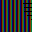

In [ ]:
Image.fromarray(np.uint8(batch[affs].data[:, 0, ...].T*255), mode='RGB')

In [ ]:
img = np.transpose(img, (2,1,0))

In [206]:
batch[lsds].data

array([[[[0.50131303, 0.5061335 , 0.5100966 , ..., 0.55174965,
          0.5462223 , 0.541031  ],
         [0.4969429 , 0.5017564 , 0.5057227 , ..., 0.5458411 ,
          0.54077274, 0.53602535],
         [0.4930865 , 0.4979056 , 0.50188583, ..., 0.5403742 ,
          0.53576905, 0.53146744],
         ...,
         [0.34552103, 0.35306206, 0.36059391, ..., 0.43598938,
          0.42904586, 0.42124188],
         [0.        , 0.        , 0.        , ..., 0.42754224,
          0.42035165, 0.41231042],
         [0.        , 0.        , 0.        , ..., 0.41850725,
          0.41112787, 0.4029115 ]],

        [[0.49013138, 0.4961076 , 0.5011307 , ..., 0.4925967 ,
          0.4930218 , 0.49361622],
         [0.48252717, 0.48897475, 0.49440753, ..., 0.48524857,
          0.4862208 , 0.4873595 ],
         [0.47538707, 0.4823241 , 0.48819032, ..., 0.47841924,
          0.47991765, 0.48157856],
         ...,
         [0.        , 0.        , 0.        , ..., 0.3766576 ,
          0.3715983 , 0.3

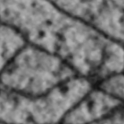

In [205]:
Image.fromarray(img, mode='L')

In [198]:
exp.url

'https://www.comet.com/valgillet/test/14f214f95faa42f6904cd3887799bb32'

In [195]:
s = 'test'
print(s)

s = "\x1b[36m" + 'test' + "\x1b[0m"
print(s)

print('test')

test
test
test


In [189]:
exp.url

'https://www.comet.com/valgillet/test/14f214f95faa42f6904cd3887799bb32'

In [6]:
import math
import random

for step in range(100):
    accuracy = math.log(1 + step + random.uniform(-0.4, 0.4))/5
    loss = 5 - math.log(1 + step + random.uniform(-0.4, 0.4))
    exp.log_metrics({'accuracy': accuracy, 'loss': loss}, step=step)

In [8]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : sensible_tread_1560
COMET INFO:     url                   : https://www.comet.com/valgillet/test/cfdee58deea94020b188731281375c7b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [100] : (-0.008687552718322408, 0.9205082313335987)
COMET INFO:     loss [100]     : (0.39882819124922975, 4.89305644719699)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     not